In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras


In [36]:
from sklearn.metrics import f1_score


# Construindo um Modelo Simples

In [37]:
from sklearn.datasets import fetch_20newsgroups


Vamos utilizar o dataset 20 Newgroups que contém posts de diferentes forums na USENET. O dataset é dividido em 20 grupos e cada grupo contém 1000 posts.

In [38]:
docs_train = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))
docs_test = fetch_20newsgroups(subset="test", remove=("headers", "footers", "quotes"))

In [39]:
docs_train["target_names"]

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [40]:
print(docs_train["data"][0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [41]:
X_text_train = docs_train["data"]
y_train = docs_train["target"]
X_text_test = docs_test["data"]
y_test = docs_test["target"]

A forma mais simples de construir um modelo de NLP (seja regressão, classificação ou mesmo não-supervisionado) é utilizando o modelo **Bag of Words**: uma matriz onde as colunas representam as palavras de nosso **vocabulário** e as linhas representam documentos individuais. Esta matriz pode ser preenchida com a contagem de cada palavra em cada documento, ou então com uma medida de frequência relativa, como o TF-IDF.

O TF-IDF normaliza a contagem de palavras penalizando palavras que aparecem em muitos documentos. A fórmula é:

$\text{tf-idf}(t, d) = \frac{\text{tf}(t, d)}{\text{idf}(t)}$

onde $\text{tf}(t, d)$ é a frequência da palavra $t$ no documento $d$ e $\text{idf}(t)$ é a frequência inversa da palavra $t$ em todos os documentos.

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [43]:
tfidf = TfidfVectorizer(
    stop_words="english",  # stop_words são palavras filtradas, como artigos, preposições etc
    max_df=0.8,  # elimina palavras que aparecem em mais de 90% dos documentos
    min_df=50,  # elimina palavras que aparecem em menos de 10 documentos
)
tfidf.fit(X_text_train)

TfidfVectorizer(max_df=0.8, min_df=50, stop_words='english')

In [44]:
tfidf.transform(X_text_train)


<11314x2725 sparse matrix of type '<class 'numpy.float64'>'
	with 430486 stored elements in Compressed Sparse Row format>

Após os filtros de *stopwords* e frequência, o vocabulário final contém 2725 palavras - nossa **matriz BoW** tem 11.314 linhas (documentos) e 2725 colunas (palavras). Vamos criar nossas matrizes de treino e teste:

In [45]:
X_train = tfidf.transform(X_text_train)
X_test = tfidf.transform(X_text_test)


A matriz BoW apresenta um grande desafio quando aplicada a problemas de NLP: ela é extremamente esparsa. A maioria dos documentos não contém a maioria das palavras do vocabulário - logo nossos features são extremamente correlatos.

Para tratar esse problema podemos usar uma técnica análoga ao PCA, chamada **Latent Semantic Analysis** (LSA). O LSA é uma técnica de redução de dimensionalidade que utiliza decomposição em valores singulares (SVD) para projetar a matriz BoW em um espaço de dimensão menor. A ideia é que palavras que aparecem em contextos similares (e.g. "carro" e "automóvel") são projetadas em um mesmo espaço, reduzindo a dimensionalidade e a correlação entre os features.

In [46]:
from sklearn.decomposition import TruncatedSVD


In [47]:
svd = TruncatedSVD(1000)
svd.fit(X_train)


TruncatedSVD(n_components=1000)

Vamos analisar o atributo `.explained_variance_ratio_` do modelo LSA para entender quanta informação capturamos com 1000 componentes:

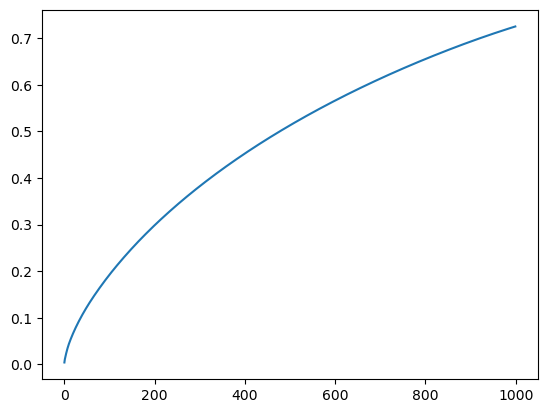

In [48]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))


Agora, vamos investigar os componentes de nosso SVD:

In [49]:
tfidf.get_feature_names_out().shape

(2725,)

In [50]:
svd.components_[0,:]

array([0.02662186, 0.02515407, 0.00497662, ..., 0.0061246 , 0.00999825,
       0.00679255])

Vamos utilizar os componentes do LSA para explorar os diferentes tópicos em nosso dataset. Para isso, vamos utilizar o atributo `.components_` do modelo LSA:

In [51]:
tb_topics = pd.DataFrame(svd.components_.T, index=tfidf.get_feature_names_out())

In [52]:
tb_topics.sort_values(4, ascending=False).head(10)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
key,0.052264,0.020460,-0.022218,0.031939,0.320675,0.063528,0.104894,-0.014133,0.376853,0.026683,...,-0.005700,-0.003192,0.004897,0.000547,-0.014782,-0.007769,0.006244,0.001463,-0.002347,-0.010246
government,0.055697,-0.059462,-0.033556,0.016527,0.184899,0.038422,0.038876,-0.038420,-0.021028,-0.105682,...,0.005768,0.003308,0.001399,-0.015174,-0.014045,0.007631,0.007044,0.019279,-0.009329,-0.000783
chip,0.040009,0.029198,-0.017515,0.003905,0.173144,0.078181,0.054071,-0.051588,0.223458,-0.010011,...,-0.006057,-0.004884,0.009160,0.029849,-0.008146,0.000107,-0.010816,-0.003986,0.003817,-0.002663
encryption,0.026035,0.000081,-0.010146,0.020694,0.164043,0.035460,0.052813,-0.025959,0.141986,-0.011477,...,-0.003081,0.000774,0.031059,0.036656,-0.015415,0.019230,-0.020672,0.011798,0.017616,0.005353
use,0.117308,0.115999,0.041768,0.002057,0.162302,0.057361,-0.018332,0.094670,0.073889,0.085745,...,-0.006135,-0.001492,0.001356,-0.003036,-0.002143,-0.004681,0.001234,0.001200,0.003180,0.004155
clipper,0.025529,-0.003456,-0.015995,0.015100,0.145777,0.035799,0.041904,-0.031055,0.145131,-0.004540,...,-0.010164,-0.003070,0.022034,-0.019071,0.027986,0.016440,0.022527,0.016017,-0.006823,0.021794
keys,0.022508,0.006795,-0.011855,0.011865,0.133328,0.032466,0.041004,-0.011715,0.140778,0.015459,...,0.005469,-0.011834,-0.004897,0.003235,0.014736,0.011366,0.015212,-0.015896,-0.011890,0.012418
people,0.155289,-0.198237,0.055401,0.014335,0.118184,0.034475,-0.042474,-0.049415,-0.188895,-0.175499,...,0.011501,-0.002927,-0.004103,-0.000120,-0.006662,-0.015185,-0.000042,-0.007696,0.002726,0.001074
public,0.034584,-0.002792,-0.000255,0.028637,0.104715,-0.000917,0.048113,-0.009646,0.038870,-0.020931,...,-0.016114,-0.005620,0.000015,-0.027002,-0.006990,-0.001073,-0.016051,-0.010826,0.001336,0.009524
law,0.043864,-0.053999,0.024663,0.018435,0.091744,0.039082,0.054446,-0.008292,0.016120,-0.051365,...,0.006332,0.000845,-0.006158,0.015336,-0.012039,-0.006588,-0.010076,-0.000511,0.001628,-0.008401


Agora vamos criar um pipeline de classificação com o modelo LSA e uma floresta aleatória de classificação:

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

tfidf = TfidfVectorizer(stop_words="english")
lsa = TruncatedSVD()
rf = RandomForestClassifier(n_jobs=-1)

modelo = Pipeline([("tfidf", tfidf), ("lsa", lsa), ("rf", rf)])

Vamos utilizar uma busca Bayesiana para otimizar os hiperparâmetros do modelo:

1. `tfidf__max_df`: Frequência máxima de uma palavra para ser considerada no vocabulário;
1. `tfidf__min_df`: Frequência mínima de uma palavra para ser considerada no vocabulário;
1. `lsa__n_components`: Componentes do SVD;
1. `rf__n_estimators`: Número de árvores na floresta;
1. `rf__max_depth`: Profundidade máxima das árvores.

In [54]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective


In [55]:
param_grid = {
    "tfidf__max_df": Real(0.7, 0.8),
    "tfidf__min_df": Integer(10, 100),
    "lsa__n_components": Integer(10, 500),
    "rf__n_estimators": Integer(50, 500),
    "rf__max_depth": Integer(16, 32),
}

In [56]:
clf_fit = BayesSearchCV(modelo, param_grid, n_iter=10)
clf_fit.fit(X_text_train, y_train)

BayesSearchCV(estimator=Pipeline(steps=[('tfidf',
                                         TfidfVectorizer(stop_words='english')),
                                        ('lsa', TruncatedSVD()),
                                        ('rf',
                                         RandomForestClassifier(n_jobs=-1))]),
              n_iter=10,
              search_spaces={'lsa__n_components': Integer(low=2, high=500, prior='uniform', transform='normalize'),
                             'rf__max_depth': Integer(low=2, high=32, prior='uniform', transform='normalize'),
                             'rf__n_estimators': Integer(low=10, high=1000, prior='uniform', transform='normalize'),
                             'tfidf__max_df': Real(low=0.7, high=0.8, prior='uniform', transform='normalize'),
                             'tfidf__min_df': Integer(low=10, high=100, prior='uniform', transform='normalize')})

Vamos visualizar nosso melhor modelo:

In [58]:
clf_fit.best_estimator_


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.7908215714496384, min_df=11,
                                 stop_words='english')),
                ('lsa', TruncatedSVD(n_components=191)),
                ('rf',
                 RandomForestClassifier(max_depth=25, n_estimators=354,
                                        n_jobs=-1))])

Agora vamos avaliar o resultado sobre o conjunto de teste:

In [20]:
y_pred = clf_fit.predict(X_text_test)
print(f"Accuracy: {clf_fit.score(X_text_test, y_test):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred, average='macro'):.2f}")


Accuracy: 0.57
F1-Score: 0.55


# Visualizando contexto com Embeddings

O modelo *Bag of Words* (saco de palavras) apresenta algumas limitações em relação à representação de texto. Essa abordagem trata cada palavra de um documento de forma isolada, desconsiderando a ordem e o contexto em que elas aparecem. Essa falta de contextualização pode levar à perda de informações importantes, como a semântica e a estrutura das frases. Além disso, o modelo *Bag of Words* não leva em consideração a similaridade entre palavras, tratando-as como entidades independentes.

Por outro lado, utilizar *embeddings* pré-treinados como o Word2Vec ou GLOVE oferece uma vantagem significativa. Esses modelos capturam relações semânticas e simbolizam as palavras em um espaço vetorial de alta dimensionalidade, onde palavras semanticamente relacionadas estão mais próximas entre si. Esses *embeddings* pré-treinados permitem que palavras com significados similares sejam representadas por vetores próximos, capturando melhor a riqueza semântica do texto. Dessa forma, é possível obter uma representação mais contextualizada das palavras, facilitando a tarefa de compreensão e análise de texto em aplicações como processamento de linguagem natural e aprendizado de máquina.

**Principais limitações do modelo Bag of Words:**
- Trata as palavras de forma isolada, desconsiderando a ordem e o contexto.
- Não leva em consideração a similaridade entre palavras.

**Vantagens dos embeddings pré-treinados:**
- Capturam relações semânticas.
- Representam as palavras em um espaço vetorial de alta dimensionalidade.
- Permitem a contextualização das palavras.
- Facilitam a compreensão e análise de texto em diversas aplicações.

Vamos utilizar a bilioteca `gensim` para incorporar embeddings em nosso modelo. Para instalar o `gensim` podemos utilizar o instalador conda:

```bash
conda install -c conda-forge gensim
```

ou `pip`:

```bash
pip install gensim
```

In [21]:
import gensim
import gensim.downloader


In [22]:
glove = gensim.downloader.load("glove-wiki-gigaword-50")

In [23]:
glove.most_similar("king")

[('prince', 0.8236179351806641),
 ('queen', 0.7839044332504272),
 ('ii', 0.7746230363845825),
 ('emperor', 0.7736247777938843),
 ('son', 0.766719400882721),
 ('uncle', 0.7627150416374207),
 ('kingdom', 0.7542160749435425),
 ('throne', 0.7539914846420288),
 ('brother', 0.7492411136627197),
 ('ruler', 0.7434254288673401)]

Embeddings são representações vetoriais das palavras - cada palavra é representada por um vetor - como no LSA cada componente representava a presença (e ausência) das palavras do nosso vocabulário. A diferença é que os embeddings são treinados em um corpus de texto muito grande, capturando relações semânticas entre as palavras. Essa técnica nos permite incorporar conhecimento de outros corpus em nosso modelo!

Vamos ver agora como podemos utilizar modelos pré-treinados para criar classificadores de NLP.

In [24]:
del glove


# Usando `Transformers` Pré-Treinados via HuggingFace

O **HuggingFace** é uma biblioteca e plataforma popular na área de Processamento de Linguagem Natural (PLN). Ele oferece uma ampla gama de ferramentas e recursos para trabalhar com modelos de PLN, sendo conhecido principalmente por sua contribuição para a pesquisa e desenvolvimento de modelos **transformers**.

O HuggingFace permite que os desenvolvedores acessem e utilizem facilmente modelos transformers pré-treinados de última geração, como o **GPT-3**, para uma variedade de tarefas de PLN, como:
- Tradução automática
- Sumarização de texto
- Geração de texto
- Análise de sentimentos

Além disso, o HuggingFace também disponibiliza uma **API** amigável para facilitar o uso desses modelos, bem como recursos de treinamento e ajuste fino para personalizar os modelos de acordo com as necessidades específicas de cada usuário.

Os modelos **transformers**, por sua vez, são uma classe de modelos de aprendizado de máquina que se destacaram na área de PLN. Eles foram introduzidos pela primeira vez em 2017 e desde então se tornaram a base para muitos avanços no campo da linguagem natural.

Esses modelos são baseados em uma arquitetura complexa de rede neural que utiliza a **atenção multi-cabeça** para processar sequências de texto. Essa arquitetura permite que os modelos capturem relações contextuais entre as palavras em um texto, o que é crucial para entender e gerar linguagem de maneira mais precisa.

Com sua capacidade de aprender e representar sequências de texto de maneira eficiente, os modelos **transformers** revolucionaram várias tarefas de PLN e têm sido amplamente utilizados para melhorar a qualidade e o desempenho de sistemas de processamento de linguagem natural em diferentes domínios.

In [30]:
from transformers import DistilBertTokenizerFast

# Primeiro, vamos inicializar nosso tokenizador pré-treinado
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

Agora precisamos preparar nossos dados para entrada no modelo. Precisaremos criar os batches manualmente a partir dos textos. Como precisamos transformar em batches de tokens tanto nosso conjunto de teste quanto de treinamento, vamos definir uma função para isso:

In [33]:
# Número máximo de palavras em um texto.
# Documentos com mais que MAX_LENGTH palavras serão divididos em 2 ou mais documentos.
MAX_LENGTH = 128

# Define function to encode text data in batches
def batch_encode(tokenizer, texts, batch_size=64, max_length=MAX_LENGTH):
    '''
    Função para codificar um lote de textos e retornar os batches de tensores
    correspondentes aos textos e suas máscaras de atenção, prontos para serem
    alimentados em um modelo de transformer pré-treinado.
    
    Input:
        - tokenizer:   Tokenizer pré-treinado
        - texts:       List de textos a serem codificados
        - batch_size:  Int que controla o tamanho dos batches
        - max_length:  Int que controla o tamanho máximo dos textos codificados
    Output:
        - input_ids:       tf.Tensor com os textos codificados
        - attention_mask:  tf.Tensor com as máscaras de atenção correspondentes
    '''

    input_ids = []
    attention_mask = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        inputs = tokenizer.batch_encode_plus(
            batch,
            max_length=max_length,
            padding="longest",
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
        )
        input_ids.extend(inputs["input_ids"])
        attention_mask.extend(inputs["attention_mask"])

    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)


# Encode X_train
X_train_ids, X_train_attention = batch_encode(tokenizer, X_text_train)

# Encode X_valid
X_test_ids, X_test_attention = batch_encode(tokenizer, X_text_test)

Agora, vamos inicializar nosso modelo pré-treinado e tornar suas camadas fixas:

In [34]:
from transformers import TFDistilBertModel, DistilBertConfig

DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.2

# Configure DistilBERT's initialization
config = DistilBertConfig(
    dropout=DISTILBERT_DROPOUT,
    attention_dropout=DISTILBERT_ATT_DROPOUT,
    output_hidden_states=True,
)

# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states
# and without any specific head on top.
distilBERT = TFDistilBertModel.from_pretrained("distilbert-base-uncased", config=config)

# Make DistilBERT layers untrainable
for layer in distilBERT.layers:
    layer.trainable = False


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Com nosso modelo pré-treinado inicializado, vamos definir nossa rede neural de fine-tuning. 

**Fine-tuning** é um processo em que um modelo de linguagem pré-treinado, como o DistilBERT, é ajustado para um conjunto de dados específico ou uma tarefa particular. Durante o pré-treinamento, o modelo é exposto a uma ampla variedade de textos e aprende representações de linguagem geral. No entanto, o *fine-tuning* permite adaptar esse modelo pré-treinado a uma tarefa específica, como classificação de sentimentos ou geração de respostas. 

Durante o *fine-tuning*, os pesos e parâmetros do modelo são ajustados usando um conjunto de dados de treinamento relacionado à tarefa em questão. Isso permite que o modelo aprenda a compreender e gerar texto de maneira mais precisa e relevante para a tarefa específica. O *fine-tuning* é essencial para adaptar modelos pré-treinados a tarefas específicas e obter um desempenho aprimorado e personalizado.



In [45]:
LAYER_DROPOUT = 0.2
LEARNING_RATE = 5e-5
RANDOM_STATE = 42

# As primeiras camadas do nosso modelo são as camadas de entrada que
# possuem dois tensores de entrada distintos: input_ids e input_attention.
input_ids_layer = tf.keras.layers.Input(
    shape=(MAX_LENGTH,), name="input_ids", dtype="int32"
)
input_attention_layer = tf.keras.layers.Input(
    shape=(MAX_LENGTH,), name="input_attention", dtype="int32"
)

# Agora, vamos inserir o DistilBERT como uma camada do nosso modelo.
# Para isso precisamos conecta-lo às camadas de entrada e criar
# uma camada de saída para o resto do modelo.
last_hidden_state = distilBERT([input_ids_layer, input_attention_layer])[0]
cls_token = last_hidden_state[:, 0, :]

# Agora, vamos definir as camadas de fine-tuning:
dense_1 = tf.keras.layers.Dense(100, activation="relu")(cls_token)
drop_1 = tf.keras.layers.Dropout(LAYER_DROPOUT)(dense_1)
dense_2 = tf.keras.layers.Dense(100, activation="relu")(drop_1)
drop_2 = tf.keras.layers.Dropout(LAYER_DROPOUT)(dense_2)

# Definindo camada de saída
## Atenção! O número de neurônios e a função de ativação da camada de saída
## são uma função do problema que estamos tentando resolver.
output = tf.keras.layers.Dense(
    20,
    activation="softmax"
)(drop_2)

# Como construímos nosso modelo utilizando a Functional API, precisamos
# amarrar as camadas de entrada e saída em um objeto do tipo Model.
model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

# Compile the model
model.compile(
    tf.keras.optimizers.legacy.Adam(lr=LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

Com nosso modelo definido e compilado resta apenas treiná-lo:

In [46]:
EPOCHS = 6
BATCH_SIZE = 64
NUM_STEPS = len(X_text_train) // BATCH_SIZE

# Train the model
train_history1 = model.fit(
    x=[X_train_ids, X_train_attention],
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch=NUM_STEPS,
    validation_split=0.1,
    verbose=2,
)

Epoch 1/6


/Users/pedroteche/miniconda3/envs/optuna/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


176/176 - 166s - loss: 3.0556 - accuracy: 0.0701 - val_loss: 2.9235 - val_accuracy: 0.1325 - 166s/epoch - 942ms/step
Epoch 2/6
176/176 - 159s - loss: 2.8756 - accuracy: 0.1375 - val_loss: 2.7697 - val_accuracy: 0.2332 - 159s/epoch - 902ms/step
Epoch 3/6
176/176 - 159s - loss: 2.7596 - accuracy: 0.2094 - val_loss: 2.6529 - val_accuracy: 0.3445 - 159s/epoch - 902ms/step
Epoch 4/6
176/176 - 158s - loss: 2.6589 - accuracy: 0.2749 - val_loss: 2.5519 - val_accuracy: 0.3746 - 158s/epoch - 897ms/step
Epoch 5/6
176/176 - 151s - loss: 2.5705 - accuracy: 0.3246 - val_loss: 2.4622 - val_accuracy: 0.4125 - 151s/epoch - 857ms/step
Epoch 6/6


176/176 - 75s - loss: 2.5130 - accuracy: 0.3422 - val_loss: 2.4221 - val_accuracy: 0.4311 - 75s/epoch - 429ms/step


# Aprendizagem Não-Supervisionada com BERTOPIC

In [47]:
from bertopic import BERTopic


/Users/pedroteche/miniconda3/envs/optuna/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pedroteche/miniconda3/envs/optuna/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pedroteche/miniconda3/envs/optuna/lib/python3.10/si

In [71]:
from bertopic.representation import MaximalMarginalRelevance

representation_model = MaximalMarginalRelevance(diversity=0.3)
topic_model = BERTopic(representation_model=representation_model)
topics, probs = topic_model.fit_transform(X_text_train + X_text_test)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [72]:
topic_model.get_topic(0)


[('games', 0.007027789245839699),
 ('players', 0.006205560524407372),
 ('season', 0.0061261280407610115),
 ('hockey', 0.006031381759577707),
 ('25', 0.005505592979640132),
 ('league', 0.004907279913881185),
 ('period', 0.004198367350311833),
 ('nhl', 0.004033391249829571),
 ('pts', 0.0036314874953981544),
 ('gm', 0.003445198692667569)]

In [73]:
topic_model.get_topic(1)


[('clipper', 0.012462800795380277),
 ('chip', 0.011734669374666327),
 ('encryption', 0.011434093144519698),
 ('escrow', 0.008489345204084982),
 ('nsa', 0.007322577292935858),
 ('encrypted', 0.0057688950163197455),
 ('security', 0.005340577251385889),
 ('crypto', 0.005111413255062783),
 ('enforcement', 0.004957826517867589),
 ('phones', 0.0046703919781765)]

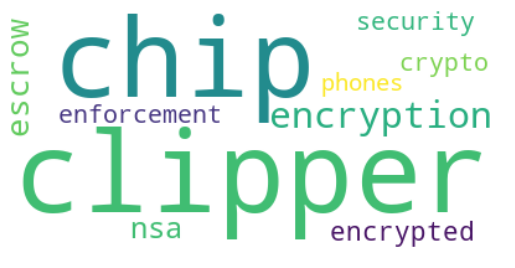

In [75]:
from wordcloud import WordCloud

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=1)

In [76]:
topic_model.visualize_barchart()

In [77]:
topics_per_class = topic_model.topics_per_class(
    X_text_train + X_text_test,
    classes=pd.Series(np.concatenate([y_train, y_test])).map(
        {i: class_names for i, class_names in enumerate(docs_train["target_names"])}
    ),
)

In [79]:
topic_model.visualize_topics_per_class(topics_per_class)